# Exercise 5: Train a ResNet

The code is used to train a ResNet34 model with CIFAR-10 dataset. The goal of this exercise is to modify a pre-trained ResNet34 model to classify CIFAR-10 images by using transfer learning technique. Moreover, we have also applied data augmentation techniques such as random rotation and horizontal flip to increase the variation in the training set. The model is trained using cross-entropy loss and optimized with stochastic gradient descent (SGD) with momentum and weight decay. We have also implemented early stopping to prevent overfitting.

In [1]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

import os
from PIL import Image
import ast
import matplotlib.pyplot as plt

os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

# Transforms for training and testing. We use the CIFAR 10 means
# and stdevs from https://github.com/facebookarchive/fb.resnet.torch/issues/180


train_transform = transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.Resize(40),             # resize shortest side to 224 pixels
        transforms.CenterCrop(32),         # crop longest side to 224 pixels at center
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
        transforms.Resize(40),
        transforms.CenterCrop(32),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])


# Load the CIFAR-10 dataset

train_dataset = datasets.CIFAR10(root='./data', transform=train_transform, download=True)
test_dataset = datasets.CIFAR10(root='./data', transform=test_transform, train=False, download=True)

# Category labels

cat_labels = [ 'airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck' ]

# Create data loaders from train/test datasets

train_dataloader = torch.utils.data.DataLoader(train_dataset, shuffle=True, batch_size=128)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128)

/opt/conda/lib/python3.9/site-packages/torchvision/io/image.py:11: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZNK3c1010TensorImpl36is_contiguous_nondefault_policy_implENS_12MemoryFormatE
  warn(f"Failed to load image Python extension: {e}")


Files already downloaded and verified
Files already downloaded and verified


### Training

In [3]:
from tqdm import tqdm

# Load the GoogLeNet model with pretrained weights and modify it to classify CIFAR-10

model = models.resnet34(pretrained=True)

model.fc = torch.nn.Linear(512, 10, bias=True)


# Set up early stopping parameters
patience = 3
best_loss = float('inf')
counter = 0

# Training loop

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
#device = "cpu"

model = model.to(device)
num_epochs = 10
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

train_losses = []
test_losses = []
train_acc = []
test_acc = []
top_5_acc = []

for epoch in range(num_epochs):
    # Iterate over the training data loader
    model.train()
    epoch_loss = 0
    iters = 0
    correct = 0
    top_5_correct = 0
    for inputs, targets in tqdm(train_dataloader):
        model.zero_grad()
        inputs = inputs.to(device)
        targets = targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        epoch_loss += loss.cpu().item()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        correct += (predicted == targets.data).sum()
        iters += 1
        train_loss = epoch_loss / iters

    # Record training loss
    train_losses.append(train_loss)
    # Record training accuracy
    train_acc.append(100 * correct / len(train_dataloader.dataset))

    #print('Epoch %d training loss %f' % (epoch, train_loss))
    
    #Testing
    model.eval()
    epoch_loss = 0
    iters = 0
    correct = 0
    top_5_correct = 0
    with torch.no_grad():
        for inputs, targets in tqdm(test_dataloader):
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            epoch_loss += loss.cpu().item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets.data).sum()
            iters += 1
            test_loss = epoch_loss / iters
            # Calculate top 5 accuracy
            _, top_5_predictions = outputs.topk(5, dim=1, largest=True, sorted=True)
            top_5_correct += top_5_predictions.eq(targets.view(-1, 1).expand_as(top_5_predictions)).sum().item()

    # Record validation loss
    test_losses.append(test_loss)
    # Record validation accuracy
    test_acc.append(100 * correct / len(test_dataloader.dataset))
    # Record top 5 accuracy
    top_5_acc.append(100 * top_5_correct / len(test_dataloader.dataset))
        
    #print('Epoch %d test loss %f' % (epoch, test_loss))
    
    # Early stopping
    if test_loss < best_loss:
        best_loss = test_loss
        best_weights = model.state_dict()
        counter = 0
    else:
        counter += 1
        if counter >= patience:
            print(f'Early stopping after {epoch} epochs.')
            break

    print(f'Epoch {epoch+1}/{num_epochs}, Train loss {train_loss:.4f}, Train acc {train_acc[-1]:.2f}, Test loss {test_loss:.4f}, Test acc {test_acc[-1]:.2f}')

100%|██████████| 79/79 [00:24<00:00,  3.23it/s]


Epoch 1/10, Train loss 0.3968, Train acc 86.31, Test loss 0.1986, Test acc 93.07


100%|██████████| 79/79 [00:25<00:00,  3.15it/s]


Epoch 2/10, Train loss 0.1799, Train acc 93.87, Test loss 0.1640, Test acc 94.33


100%|██████████| 79/79 [00:23<00:00,  3.33it/s]


Epoch 3/10, Train loss 0.1257, Train acc 95.66, Test loss 0.1604, Test acc 94.37


100%|██████████| 79/79 [00:27<00:00,  2.84it/s]


Epoch 4/10, Train loss 0.1024, Train acc 96.41, Test loss 0.1677, Test acc 94.59


100%|██████████| 79/79 [00:26<00:00,  2.99it/s]


Epoch 5/10, Train loss 0.0823, Train acc 97.13, Test loss 0.1701, Test acc 94.70


100%|██████████| 79/79 [00:26<00:00,  3.02it/s]


Epoch 6/10, Train loss 0.0693, Train acc 97.50, Test loss 0.1334, Test acc 95.70


100%|██████████| 79/79 [00:24<00:00,  3.18it/s]


Epoch 7/10, Train loss 0.0612, Train acc 97.86, Test loss 0.1546, Test acc 95.14


100%|██████████| 79/79 [00:25<00:00,  3.08it/s]


Epoch 8/10, Train loss 0.0557, Train acc 98.06, Test loss 0.1638, Test acc 95.22


100%|██████████| 79/79 [00:27<00:00,  2.91it/s]

Early stopping after 8 epochs.


### Visualize Loss & Accuracy of Train & Test dataset

<function matplotlib.pyplot.show(close=None, block=None)>

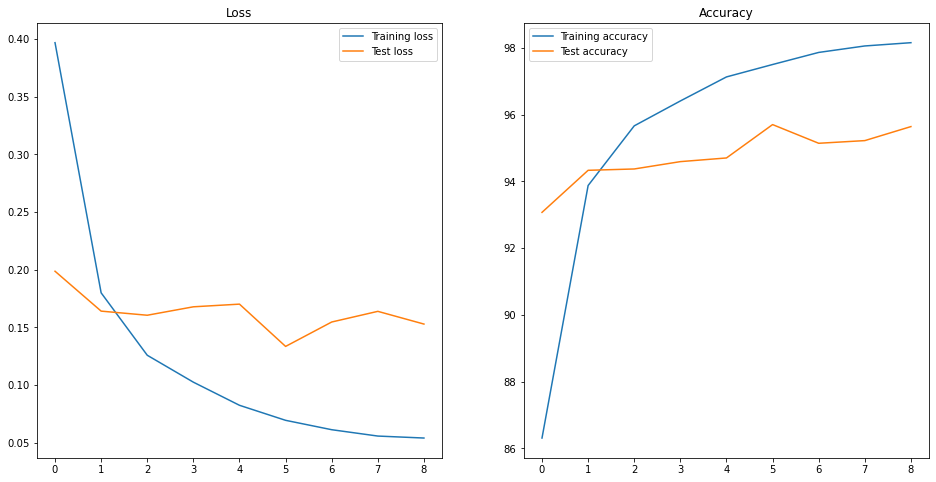

In [4]:
fig = plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.title('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot([x.cpu() for x in train_acc], label='Training accuracy')
plt.plot([x.cpu() for x in test_acc], label='Test accuracy')
plt.title('Accuracy')
plt.legend()
plt.show

Final Top-5 Accuracy: 99.92


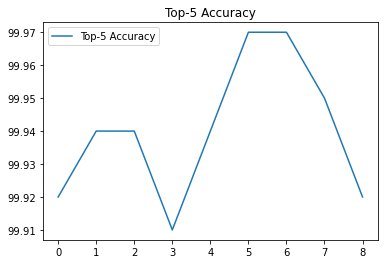

In [9]:
#fig = plt.figure(figsize=(16, 8))
plt.plot(top_5_acc, label='Top-5 Accuracy')
plt.title('Top-5 Accuracy')
plt.legend()
print(f"Final Top-5 Accuracy: {top_5_acc[-1]}")

### Display some images in Testset with actual & predicted labels

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


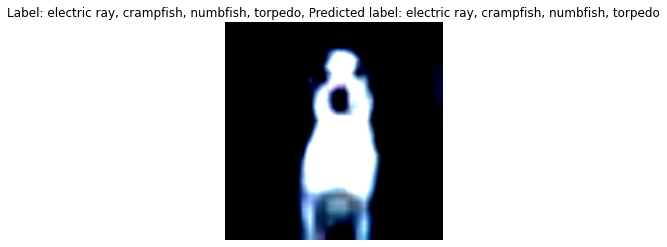

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


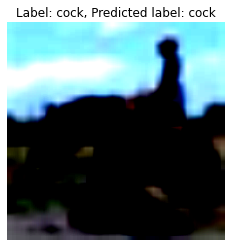

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


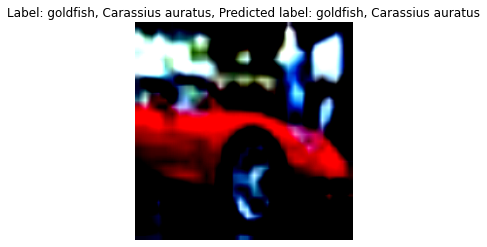

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


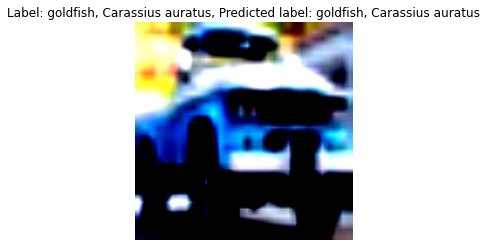

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


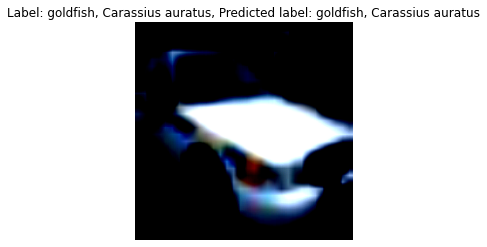

In [11]:
# Get ImageNet class labels
with open('imagenet1000_clsidx_to_labels.txt') as f:
    label_data = f.read()
class_labels = ast.literal_eval(label_data)

# Select a random image from the dataset
import numpy as np
idx = np.arange(len(test_dataset))
np.random.shuffle(idx)
for x in range(5):
    inputs, label = test_dataset[idx[x]]
    output = model(inputs.to(device).unsqueeze(0) )
    _, predicted_label = torch.max(output.data, 1)
    plt.imshow(np.transpose(inputs.numpy(), (1, 2, 0)))
    plt.title(f"Label: {class_labels[label]}, Predicted label: {class_labels[predicted_label.item()]}")
    plt.axis('off')
    plt.show()

## Conclusion:
In this code, we have trained a ResNet34 model with CIFAR-10 dataset using transfer learning technique. The model was pre-trained on ImageNet dataset, and then modified to classify CIFAR-10 images. We have also applied data augmentation techniques such as random rotation and horizontal flip to increase the variation in the training set. The model was trained using cross-entropy loss and optimized with stochastic gradient descent (SGD) with momentum and weight decay. Early stopping was used to prevent overfitting. The results of the training and testing showed good accuracy, which indicates that the model is able to classify CIFAR-10 images effectively.